In [1]:
from math import *
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
plt.rc('font', size=14)

# Carbon Precision Considerations -- DRAFT

## Storage requirements for A,B

### Prices

We are here discussing the storage requirements for crypto prices. Prices have the following components

- **Precision**: in traditional financial markets we usualy want prices to be quoted with 5 significant digits, which corresponds to a range of $10^6$ or $3.3*6 \simeq 20$ bits.

- **Range**: in crypto, the price ranges is rather wide; against the USD alone, we need to contemplate at least $10^5$ on the upside (BTC) and $10^{-5}$ on the downside (SHIB). If we use BTC/SHIB as an example this means a range of at least $10^{10}$, and we need to double this range to $10^{20}$ to account for reverse quotation of the price. This gives use $20*3.2 \simeq 64$ bits on the range.

- **Decimals**: a pecularity in crypto is that display prices are not _real_ prices because of decimality: what matters when exchanging two tokens is not the display price, but the price of the underlying _token-wei_. Most tokens are 18 decimals, some important ones (stable coins in particular) are 6 decimals. A very small number of tokens has 24 decimal, and a few hundred have between 6 and 0. A decimality difference of 12 (18/6) corresponds to $12*3.3 \simeq 40$ bits, and difference of 18 (18/0 or 24/6) corresponds to $18*3.3 \simeq 60$ bits. We do not consider the 24/0 case relevant because of the small number of tokens concerned.  

Summing up the bits gives us 20 for precision, 64 for ranges, and 40 or 60 for decimals, yielding a **total of 124 or 144 bits**. We could probably shave a few bits off when looking at the correlation between the factors -- eg low decimality tokens may have low prices to compensate -- but this is a refinement that is outside the scope of the current analysis.

#### Trimming down the 18/6 and 18/18 cases
One simplification we however want to make is to assume that in the 18/6 case we do not have to cover the full range of possible prices, ie we assume that the only meaningful cases we need to cover in 18/6 are stable coins. So we have the two following case

- **18/18**: on 18/18 tokens we need to support the full range of prices; this means 20 bits for precision and 64 bits for range, ie **a total of 84 bits**

- **18/6**: on 18/6 tokens we assume that our price range is only $10^{5}$, essentially SHIB/USDC. So in this case we need 20 bits for precision, 32 bits for range, and 40 bits for decimals, ie a **total of 92 bits**.

In [2]:
log2(10)

3.321928094887362

### The coefficients A,B

The coefficients b, a are defined as $b=\sqrt{P_b}$ and $a=\sqrt{P_a}-\sqrt{P_b}$ respectively. We note first that this means that on the face of it, the number of bits required are half those of prices, so we'd get 62 or 72 respectively. We however need to point out that the "precision" is not equally distributed along the range. Naive considerations may lead to the result that, because the relationship between $B$ and $P_b$ is quadratic, the precision gets worse for bigger prices. The reality however is the other way round, the reason being that we have to look at relative price changes. For those we get:

$$
\frac{\Delta P} P = \frac {(B+1)^2}{B^2} = \frac {2 + 1/B} B \simeq \frac 2 {\sqrt P}
$$



In average, we get the following requirements for the number of bits needed

- For the full case 62 (or 72) bit
- For the 18/18 case 42 bit
- For the 18/6 case 46 bit


However, this is only true _in average_. The problem is that a lot of those grid points will be located towards the higher prices, and they will be very sparse toward the low prices. So whilst the above resolutions may be correct _in average_ they may not be sufficient across the entire range.

We will for the time being ignore the fact that A is not actually the square root of a price, but the _difference_ of two such square roots, but we do note that this may yield _increased_ requirements for the precision of the numbers concerned.

Below we estimate the grid size we get at the lower end of the price range. The number plotted is $P(B+1)/P(B)-1$, ie the percentage change between two adjacent values of $B$ [eg $10^{-2}=1\%$]. We see that it goes linear in a log / log plot. If we want a 1% price grid we are at about $B=200$, and for a 1bp price grid at about $B=20,000$.

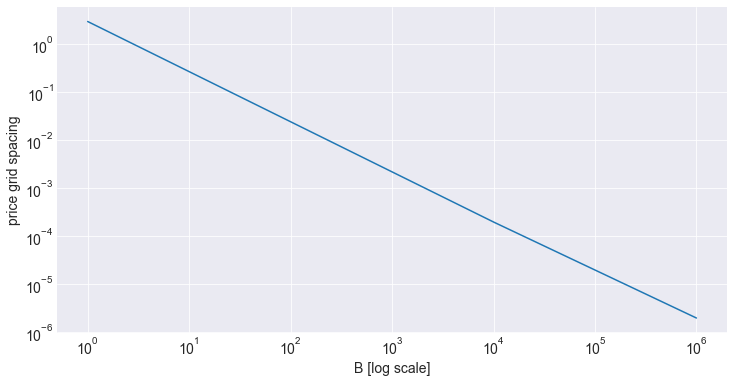

In [3]:
B_r = np.linspace(1,1e6,100)
plt.plot(B_r, [(B+1)**2/B**2 - 1 for B in B_r])
#plt.ylim(0,1)
plt.xlabel("B [log scale]")
plt.ylabel("price grid spacing")
plt.yscale("log")
plt.xscale("log")
plt.grid()

Expressing this in numbers of bits gives us about 8 bits for 1% price accuracy, 11 bits for 10bp accuracy, and 14 bits for 1bp.

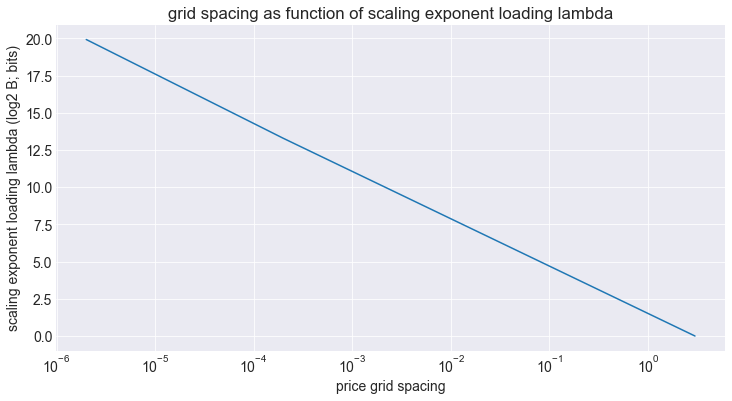

In [4]:
B_r = np.linspace(1,1e6,100)
plt.plot([(B+1)**2/B**2 - 1 for B in B_r], np.log2(B_r), )
plt.ylabel("scaling exponent loading lambda (log2 B; bits)")
plt.xlabel("price grid spacing")
plt.xscale("log")
plt.title("grid spacing as function of scaling exponent loading lambda")
plt.grid()

### The scaling factor

Last but not least we need to keep the scaling in mind. When trading by source, we are using the following equation


$$
\Delta x = \frac 1 {s^2} \cdot \frac{\Delta y\, (Ay+Bz)^2}{\Delta y\, A(Ay+Bz)+z^2 s^2} 
$$

and when we are trading by target the following equation

$$
\Delta y = \frac{\Delta x\, s^2 z^2}{(Ay+Bz)(Ay+Bz+A\Delta x)} 
$$

in both cases the coefficient $s$ is a scaling factor, which we currently set to

$$
s = 2^{x_s} = 2^{32}
$$

The number of bits required for the scaling factor is $x_s$, which in the current implementation is 32 bits. 

The interaction between the scaling factor and the above numbers is somewhat complex -- essentially the scaling factor is there to (a) allow for numbers < 1 to be transmitted into the contract, and to (b) scale the numerator of the above equations to a multiple of its denominator. So there is a certain amount of double counting here, but it is not entirely clear how much. **We assume for the time being full double counting, ie we do not consider any extra size requirements due to the scaling factor.** We believe this to make sense, but we do need to point out this is an aggressive assumption, and that we may need to revise it at a later stage.

### Conclusion on prices

We have shown above that only about 20 bits are required to obtain a reasonable resolution of $10^{-5}$ on the prices, both via direct estimation and by looking at the charts. The remainder of those bits -- ie the largest portion of the requirement -- is because of scaling. This is similar in the decimal case to a situation where we have eg 1.2345 vs 0.00000012345 vs 12,345,000,000. It is well known that the most efficient way to represent numbers with constant precision requirements across a wide scale _in storage_ is through a floating point representation. Here specifically we could go for a _storage_ representation of

$$
B = 2^{x_B} \cdot B_0
$$

with $b_0$ being a 20 bit number (for precision) and the exponent $x_b$ being well inside an 8 bit range. If we are generous, we can increase the storage size of $B_0$, but a value of 40 should be plenty. We want to stress here that this representation only applies for the storage considerations of those coefficients. **For actual calculations within the EVM they will be expanded to regular 256 bit integers.**

## Scaling factor

The optimal choice of the scaling factor is driven by two competing requirements. 

1. **Granularity**. The numbers a,b must be big enough that the above _trade by source_ and _trade by target_ equations read sensible results without too much rounding errors. A necessary -- but probably not sufficient -- precondition for this is that the truncated representation of the prices is close enough to the prices desired by the user. In other words -- the price grid spanned by the prices generated by the discrete values of $A,B$ must be sufficiently dense at all relevant price points (this is addressed in the charts above)

2. **Overflow**. At the opposite end of the spectrum lies the overflow risk: throughout the calculation, all numbers obtained must fit into 256 bit unsigned integers (see the pseudo code below for details). Our preliminary analysis suggests that currently usually the binding constraint is the trade by target function, and specifically the term `temp2*temp3`. This term is effectively proportional to $s^2 z^2 \sqrt P$ where $P$ is some reference price level for the range.

We currently have a scaling factor of 32, and an associated representation of $A,B$ as 64 bit integers. A scaling factor of 32 seems to be a good compromise that works in many of the situations we have studied. However, we have found issues arising in particular in the case of SHIB/USDC where the decimality is 18/6 and the price is of the order of $10^{-5}$. We are now proposing the increase the scaling factor to $2^{40}$ _for all curves_ and commensurately increase the storage of a,b to 80 bits.

**We have now established that the 40 bit proposal does not, in the cases where it matters, improve over the current 32 bit state, so for the time being it is being scrapped.**

## Can smart scaling address the overflow and precision issues at the same time?

### Summary
We know that the optimal choice of the scaling factor matters greatly because there lies failure at both ends of it: if it is too large, the calculation will overflow already at small curve loadings, and if it is too small then the price grid is very wide [see the charts above] and entirely disappears below a certain point.

The idea behind that dynamic scaling factor was that as we clearly can not find a single scaling factor that works across _all_ curves, we may be able to choose this compromise on a curve-by-curve level, so that on curves that are prone to overflow we choose a smaller factor, and on curves that present too coarse a price grid we choose a bigger factor. It turns out unfortunately that what appears to be the most important overflow in practice is strongly correlated to the coarseness of the price grid, ie those problems appear in tandem. In other words: **it is not possible to address what appears to be the most important overflow issue by changing the scaling factor, either dynamic or static.**

This leaves us two options: (1) the use of a big number library, and (2) a different kind of rescaling where we reduce the decimality of the offending token virtually. This works because the problem lies in low value tokens that on to of this are divided in very many decimals that are traded against higher value tokens divided into fewer decimals. It is clear that not every desired output value can be achievedL one token wei of the higher value token corresponds to a very large (mid-size-power-of-ten-large) amount of the lower value token, and this is the smallest possible chunk that is tradeable in this case anyway.

### Details

We have seen the issue of price granularity first arising that the SHIB/USDC pair which trades at both a very low value (1 SHIB ~ 1e-5 USD) and has a big decimalty differential (USDC has 6, SHIB the standard 18). Our propopsed solution was to increase the scaling factor from $2^{32}$ to $2^{40}$ on this particular curve to address the granularity issue there, whilst not increasing the overflow risk elsewhere. Unfortunately it turned out that this particular curve was not only at risk of low granularity, but also at risk of overflow, which means that any increase in scaling factor -- dynamic or static -- just shifts the problem from a price-grid problem to a curve size problem. For reference -- at scaling factor of $2^{32}$, SHIB had a grid granularity of about 30% at this price point, and at the same time a maximum curve loading of 15,000 USDC. The latter makes it clear that there was no room to increase the scaling factor.

Further analysis suggests that this is not by chance. Details are somewhat complex, but on a high level they are the following: our exchange formulas are predicated upon the exchange of token wei against token wei, and in the cases where things break we have two effects pushing in the same direction: not only the actual price itself is very low, but also the price per token wei is even lower (to the tune of $10^{12}$ lower in this case) because of the differential in decimals. In order to allow for sufficient price granularity we need to place ourself at a certain minimum point in $B$ space -- details are in the charts above, but generally we need a $B$ between 1,000 and 1,000,000 for price granularity to be sufficient (and of course we need at least $B=1$ to have a price in the first place). Because of the way our price formula is structured, this point in $B$ space corresponds to exactly one token wei of the low value token. 

This is the crux of the problem: we fix the location of 1 token wei of the low value token at a certain minimum point in $B$ space. Because of this fixing, there is a maximum headroom in $B$ space at any given number of bits, meaning that there is a maximum multiple of bs that we can pack onto the curve before overflow happens. As a consequence, our curve capacity, measured in token wei of the low value token, can never exceed a fixed number that is only driven by the number of bits in our implementation. This implies that, the lower the price of one token wei of the low value token is compared to one token wei of the high value token*, the lower the maximum amount, measured in the high value token, that we can pack on the curve. 

There are only two ways we can address this issue:

1. Increase the headroom by using a big number library
2. Change the trading formulas to allow for decimality scaling, ie to treat the low value token as if it had a higher decimality as it actually has

Whilst the latter seems to be in contradiction of the stated trading goals especially when trading by target it is important to understand that (1) those trading goals are not achievable anyway because of the lack of inputs granulariy, and (2) the actual difference will be de minimis, and lower by order of magnitudes than the fees we charge, even at very low levels of fees. 


*note that in theory it is mostly decimality that matters: even a higher value token will ultimately be too low in value per token wei if the decimality is too high; however, this currently has no practical implications because no such tokens exist

## Pseudo code

### Code parameters

Throughout the code below, we make the following definitions

Firstly, the **lower case variables $a,b$** are related to the prices of the range boundary $P_a, P_b$, expressed in units source token $y$ per unit of target token $x$ ("$dy/dx$") and $P_a \geq P_b$. The variables $a,b$ are defined as follows:

$$
a=\sqrt{P_a}-\sqrt{P_b} \\
b=\sqrt{P_b}
$$

The **upper case variables $A,B$** are obtained by rescaling $a,b$ and truncating them to _integer_ values, where the rescaling includes both the decimality adjustment and the scaling factor used in the smart contracts; specifically for $B$ we get

$$
B = \mathrm{int}\left(2^{X_S}\cdot 10^{\frac{\Delta d} 2} \cdot b\right)
$$

and the same for the values $A, a$. Here

$$
2^{X_S} = S
$$

is the scaling factor applied for numerical optimisation, and $\Delta d$ is the _difference_ in decimality in the two tokens. The sign of $\Delta d$ is such that $10^{\Delta d} P_{a|b}$ is the correct price for $dy_\mathrm{wei}/dx_\mathrm{wei}$, ie the number of token-wei of $y$ that are equivalent to 1 token-wei of $x$ at this price point. 

This latter statement makes it clear why the factor $S$ is needed and what is minimum size must be: depending on price and decimality difference, the number of $dy_\mathrm{wei}$ we get for one $dx_\mathrm{wei}$ can be very small, and the factor $S$ must compensate for that. Specifically

$$
2^{X_S} > 10^{\frac{\Delta d} 2} \cdot b \cdot 2^{\lambda}
$$

where $\lambda$ is some minimum number of digits we want $B$ to have (eg $\lambda=10\ldots 20$). We can solve for $X_S$ using

$$
X_S \geq 3.4 \left(\frac{\Delta d} 2 + \log(b)\right) + \lambda
= 1.7 (\Delta d + \log(P)) + \lambda
$$

where $3.4 \simeq \log_2(10)$ and $\log=\log_{10}$ is the logarithm with basis 10.

To use two archetypical examples, let's start with y=USDC and x=ETH, so $dy/dx$ is USDC per ETH and about 2,000. USDC is of decimality 6, and ETH of 18, so the difference is 12. The price ratio on the Wei level is therefore $2000 / 10^{12}$, so one USDC-Wei equals 2e9 ETH-Wei. For the scaling exponent we get $X_S \geq 1.7 (12-3.3) + \lambda = \lambda + 14.8$. 

Our other example is y=USDC again, but now we have x=SHIB, and the price is 5e-5 USDC per SHIB. The decimality is the same, put it pushes an already low price even lower, so 1 USDC-Wei equals 5e17 SHIB-Wei. For the scaling exponent we get $X_S \geq 1.7 (12+4.3) + \lambda = \lambda + 27.7$

In [5]:
log2(10), log10(2000), log10(1.4e-5)

(3.321928094887362, 3.3010299956639813, -4.853871964321762)

In [6]:
xs = lambda d,P: 0.5*log2(10)*(d-log10(P))
xs(12,1.4e-5)

27.993675392957456

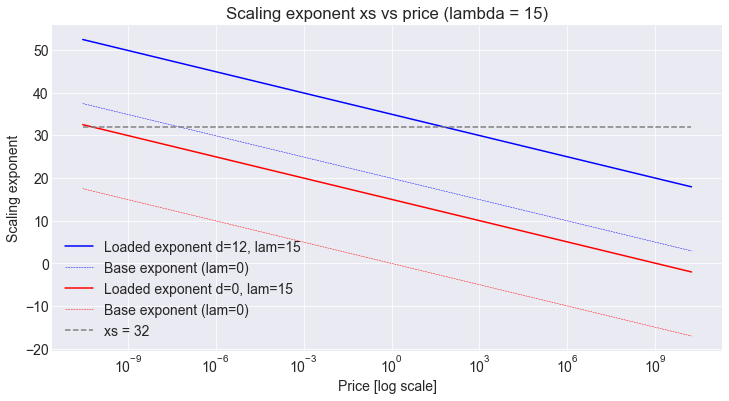

In [7]:
P_r = [2**xp for xp in range(-35, 35)]
lam=15
for dd, col in [(12, "blue"), (0, "red")]:
    plt.plot(P_r, [xs(dd, p)+lam for p in P_r], color=col, label=f"Loaded exponent d={dd}, lam={lam}")
    plt.plot(P_r, [xs(dd, p)+0 for p in P_r], color=col, linewidth=0.5, linestyle="dashed", label=f"Base exponent (lam=0)")
plt.plot(P_r, [32 for p in P_r], label="xs = 32", color="grey", linestyle="dashed")
#plt.plot(P_r, [40 for p in P_r], label="xs = 40", color="grey", linestyle="dashed")
plt.xscale("log")
plt.ylabel(f"Scaling exponent")
plt.xlabel("Price [log scale]")
plt.title(f"Scaling exponent xs vs price (lambda = {lam})")
plt.legend()
plt.grid()

### Data storage and constants

In [8]:
MAX = 2 ** 112

In [9]:
def readStorage():
    y   = read("y")     # curve liqudity
    z   = read("z")     # curve capacity 
    A   = read("A")     # A coefficient, base number
    xA  = read["xA"]    # ditto, exponent
    B   = read("B")     # B coefficient, base number 
    xB  = read["xB"]    # ditto, exponent
    xs  = read["xs"]    # scaling exponent
    
    s  = 2**xs
    a *= 2**xA
    b *= 2**xB
    return y,z,A,B,s

### Trade by source


In [10]:
def getTradeTargetAmount_bySource(dy):

    y,z,A,B,s = readStorage()
    ONE = s
    temp1 = y * A + z * B               # 177 bits at most; cannot overflow
    temp2 = temp1 * dy / ONE            # 224 bits at most; can overflow; some precision loss
    temp3 = temp2 * A + z * z * ONE     # 256 bits at most; can overflow
    dx = mulDiv(temp1, temp2, temp3)
    assert dx < MAX
    return dx

### Trade by target

note: in practice, the term `temp2*temp3` is the most likely to overflow across both functions.


In [11]:
def getTradeSourceAmount_byTarget(dx):

    y,z,A,B,s = readStorage()
    ONE = s
    temp1 = z * ONE                                 # 144 bits at most; cannot overflow
    temp2 = y * A + z * B                           # 177 bits at most; cannot overflow
    temp3 = temp2 - dx * A                          # 177 bits at most; can underflow
    dy = mulDiv(x * temp1, temp1, temp2 * temp3)    # each multiplication can overflow
    assert dy < MAX
    return dy